In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [48]:
otu_df = pd.read_csv('dataframes/OTU.csv', sep='\t', index_col='OTU')
taxonomy_df = pd.read_csv('dataframes/hiera_BLAST.csv', sep='\t', index_col='OTU')
metadata_df = pd.read_csv('dataframes/YOGURT-MAP.csv', sep='\t', index_col='#SampleID')
path_df = pd.read_csv('dataframes/path_df.csv', sep = ',')
metadata_df = metadata_df.drop(columns=['fastqFile', 'Weight'])
otu_df_meta = otu_df.transpose()
merged = otu_df_meta.merge(metadata_df, left_index=True, right_index=True)
merged = merged.reindex(['Group'] + list(merged.columns[:-1]), axis=1)
merged = merged[~merged['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
merged['Group'] = merged['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
#merged = merged.drop(['AB10','BA10'])
merged_absolute = merged.copy()
#merged_absolute.to_excel('dataframes/output_data/16.07/taxonomy/initail_data_tax.xlsx')
#merged_absolute.to_csv('dataframes/output_data/16.07/taxonomy/initail_data_tax.csv', sep='\t', index=True)


In [49]:
genus_df = otu_df.groupby(taxonomy_df['Genus']).sum()
family_df = otu_df.groupby(taxonomy_df['Family']).sum()
genus_df = genus_df.T
genus_df = genus_df.merge(metadata_df, left_index=True, right_index=True)
genus_df = genus_df.reindex(['Group'] + list(genus_df.columns[:-1]), axis=1)
genus_df = genus_df[~genus_df['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
genus_df['Group'] = genus_df['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
genus_df = genus_df.drop(columns={'?'})
cols = genus_df.columns.tolist()
modified_cols = [cols[0], cols[1]] + ["g_" + col for col in cols[2:]]
genus_df.columns = modified_cols
genus_df = genus_df.rename(columns={'A2':'g_A2'})

In [51]:
import pandas as pd

# Предполагается, что df - ваш текущий DataFrame

# Фильтрация по группам "CN" и "CMC"
genus_df_cmc = genus_df[genus_df['Group'].isin(['CN', 'CMC'])]
genus_df_cmy = genus_df[genus_df['Group'].isin(['CN', 'CMY'])]

In [54]:

def relative_abundance(df):
    # Создаем копию набора данных для избежания предупреждения
    df_copy = df.copy()
    # Добавляем столбец с общим количеством OTU для каждого образца
    df_copy['OTU_total'] = df_copy.iloc[:, 1:].sum(axis=1)

    # Рассчитываем относительное изобилие
    df_copy.loc[:, df_copy.columns[1:-1]] = df_copy.loc[:, df_copy.columns[1:-1]].div(df_copy['OTU_total'], axis=0)

    # Удаляем столбец OTU_total, так как он нам больше не нужен
    df_copy.drop(columns=['OTU_total'], inplace=True)
    # df_copy = df_copy.applymap(lambda x: str(x).replace('.', ','))
    # df_copy.T.to_excel('dataframes/output_data/16.07/taxonomy/otu_relative_abundance.xlsx')
    return df_copy.loc[:, (df_copy != df_copy.iloc[0]).any()] 


rel_genus_df_cmc = relative_abundance(genus_df_cmc)
rel_genus_df_cmy = relative_abundance(genus_df_cmy)


In [57]:
import scipy.stats as stats

def kruskal_pvalues_filter(df, group1):
    # Разделяем датафрейм на две группы
    group_cmc = df[df['Group'] == group1]
    group_cn = df[df['Group'] == 'CN']

    # Тест Kruskal-Wallis
    kruskal_pvalues = [stats.kruskal(group_cmc[otu], group_cn[otu], nan_policy='omit')[1] for otu in df.columns[1:]]

    # Создание DataFrame для хранения результатов
    results = pd.DataFrame({
        'OTU': df.columns[1:],
        'Kruskal_pvalue': kruskal_pvalues,
    })

    # Средние значения для каждой группы
    results['CN_mean'] = group_cn.mean(numeric_only=True).values
    results[f'{group1}_mean'] = group_cmc.mean(numeric_only=True).values

    results = results.loc[results['CN_mean'] > 0.001]
    results = results.loc[results[f'{group1}_mean'] > 0.001]
    return results.loc[(results['Kruskal_pvalue'] <= 0.05)]

kruskal_genus_cmc = kruskal_pvalues_filter(rel_genus_df_cmc, 'CMC')
kruskal_genus_cmy = kruskal_pvalues_filter(rel_genus_df_cmy, 'CMY')


In [62]:
def transpose_df(df):    
    less_zero_five_transposed = df.T
    less_zero_five_transposed.columns = less_zero_five_transposed.iloc[0]
    return less_zero_five_transposed[1:]

kruskal_genus_cmc_transposed = transpose_df(kruskal_genus_cmc)
kruskal_genus_cmy_transposed = transpose_df(kruskal_genus_cmy)

def preparing_data(started_df, transposed_df):
    # Сначала получим список всех OTU в merged_deleted_cmc_rel
    all_otus_in_merged = started_df.columns.to_list()

    # Затем получим список всех OTU в less_zero_five_transposed
    otus_in_less_zero_five_transposed = transposed_df.columns.to_list()

    # Определим, какие OTU присутствуют в merged_deleted_cmc_rel, но отсутствуют в less_zero_five_transposed
    otus_to_drop = [otu for otu in all_otus_in_merged if otu not in otus_in_less_zero_five_transposed and otu != 'Group']

    # Теперь удалим эти столбцы из merged_deleted_cmc_rel
    return started_df.drop(columns=otus_to_drop)

merged_deleted_cmc_rel_dropped = preparing_data(rel_genus_df_cmc, kruskal_genus_cmc_transposed)
merged_deleted_cmy_rel_dropped = preparing_data(rel_genus_df_cmy, kruskal_genus_cmy_transposed)

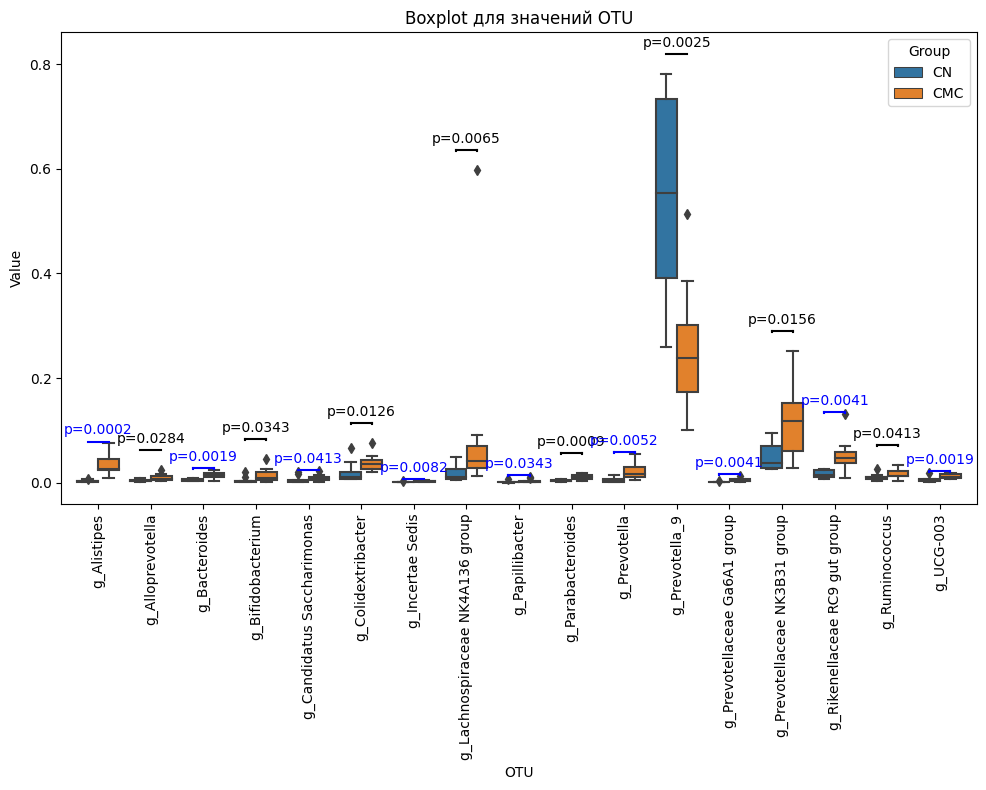

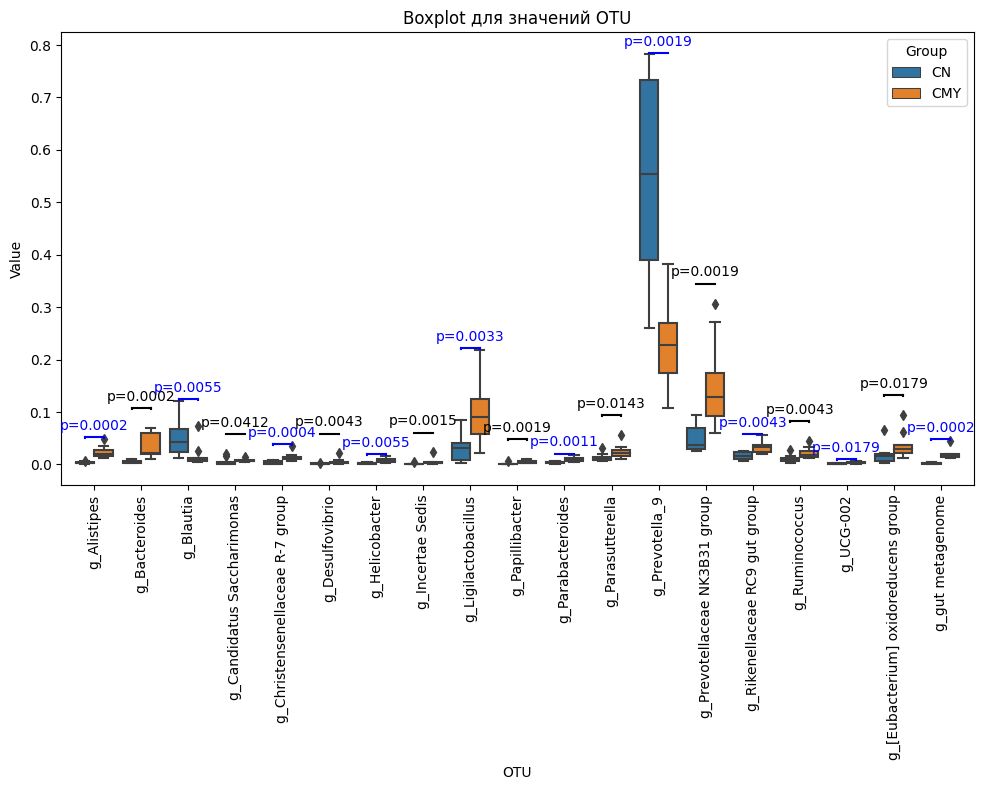

In [65]:
def relative_abundance_boxplot(df_dropped, transpose_df, df_group):
    # Преобразуем данные в длинный формат с помощью функции melt в pandas
    data_melt = df_dropped.melt(id_vars='Group', var_name='OTU', value_name='Value')

    # Фильтруем данные только для групп CN и CMC
    data_melt = data_melt[data_melt['Group'].isin(['CN', df_group])]

    # Создаем boxplot
    if df_group == "CMY":
        plt.figure(figsize=(10, 8))
    else:
        plt.figure(figsize=(10, 8))

    ax = sns.boxplot(data=data_melt, x='OTU', y='Value', hue='Group')

    # Получаем значения p-value
    p_values = transpose_df.loc['Kruskal_pvalue'].to_dict()

    # Находим максимальное значение y для каждого OTU
    y_max_values = data_melt.groupby('OTU')['Value'].max()

    # Выводим значения p-value и линии для групп 'CN' и 'CMC'
    for i, otu in enumerate(data_melt['OTU'].unique()):
        p_value = p_values.get(otu, np.nan)
        y_max = y_max_values[otu]
        if i % 2==0:
            height = 0.003
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10, color = 'blue')
        else:
            height = 0.038
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10)
        
        # Добавляем вертикальные линии
        x1 = i - 0.2
        x2 = i + 0.2
        
        line_width = 1.5
        y_line = y_max + height  # Y-координата горизонтальной линии
        if i % 2==0:
            line_color = 'blue'
            ax.plot([x1, x1], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия
        else:
            line_color = 'black'
            ax.plot([x1, x1], [y_max+.037, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.037, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия

    # Показываем график
    plt.title('Boxplot для значений OTU')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # if df_group == "CMY":
    #     plt.savefig('figures/realtive_ab/seaborn_boxplot_cmy.pdf', bbox_inches = 'tight')
    # else:
    #     plt.savefig('figures/realtive_ab/seaborn_boxplot_cmc.pdf', bbox_inches = 'tight')
    plt.show()

relative_abundance_boxplot(merged_deleted_cmc_rel_dropped, kruskal_genus_cmc_transposed, 'CMC')
relative_abundance_boxplot(merged_deleted_cmy_rel_dropped, kruskal_genus_cmy_transposed, 'CMY')